In [ ]:
#Lab 11 MNIST and Deep Learning CNN
#(https://wikidocs.net/60324) 참고

In [29]:
import pandas as pd
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random
import torch.nn.init
import matplotlib.pyplot as plt
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

In [5]:
#reproducible한 실험을 하기 위해 시드를 고정해둘 필요가 있다. 
#Pytorch에서 무작위성을 배제하고 일관된 학습 결과를 얻으려면 다음과 같은 코드를 사용하면 된다. 
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

(https://moding.tistory.com/entry/Learning-Rate-Training-Epoch-Batch-Size%EC%9D%98-%EC%9D%98%EB%AF%B8)
learning_rate training epochs, batch_size 개념
1) learning_rate : alpha값, 기울기의 변화폭을 정해주는데 너무 커도, 너무작아도 안되므로 보통 lr=0.01로 시작한다.
2) 1 epoch : 전체 데이터셋에 대해 한 번 학습을 완료한 상태
3) batch_size : 한번 학습을 할때 데이터를 쪼갠 크기, 메모리의 한계와 속도 저하를 막기 위해
4) iteration : 1000개의 데이터셋, batch_size = 100이면 1epoch = 1000/batch_size = 10 iteration

### 뿐만아니라, transforms를 정의할 수 있고, shuffle, num_workers를 정의하는 등 다양한 option 값으로 매우 손 쉽게 datasets를 컨트롤 할 수 있습니다.

In [6]:
#parameters
learning_rate = 0.001
traning_epochs = 15
batch_size = 100

In [7]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [8]:
print(mnist_train)
print('-')
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()
-
Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [9]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

### drop_last = True
drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.

In [10]:
#CNN MODEL
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        #-------------------------------------------------------------#
        # L1 ImgIn shape=(?, 28, 28, 1)=(?,가로,세로,filter or channel)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
        #Conv2d를 거친 후 Pooling을 Max방법으로 구한다(14,14,32이미지를 kernel_size=2, stride=2로 pooling)
        #-------------------------------------------------------------#
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        #-------------------------------------------------------------#
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        #-------------------------------------------------------------#
        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight) #가중치 초기화 : xavier_uniform or HE_uniform 방법이 주로 쓰이는데 he_uniform이 최근 자주쓰임
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out   

In [11]:
# instantiate CNN model
model = CNN().to(device)

In [12]:
# define cost/loss & optimizer
#cross entrophy : info가 틀릴수 있는 정도(확률), softmax(Q라고 쓰임) : Estimated Probability, P는 True Probability이다.

# torch.nn.CrossEntropyLoss는 nn.LogSoftmax와 nn.NLLLoss의 연산의 조합이다.
#nn.LogSoftmax는 신경망 말단의 결과 값들을 확률개념으로 해석하기 위한 Softmax 함수의 결과에 log 값을 취한 연산이고,
#nn.NLLLoss는 nn.LogSoftmax의 log 결과값에 대한 교차 엔트로피 손실 연산(Cross Entropy Loss|Error)
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed. 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#머신러닝 알고리즘에서 최적화는 비용함수의 값이 가장 작아지는 최적의 파라미터를 찾는 과정을 말하며, 비용함수는 손실함수를 사용하여 정의될 수 있다.

### Cross-Entrophy : H(P,Q)이며, log값에 p대신 q(estimated probability)를 쓴다(그림)
1. Cross Entrophy에서 log q를 쓰는 이유 : 정보의 양인 log(1/q)은 예측값인 q를 쓰는게 정확한 예측을 할 수 있다.크로스엔트로피 값이 
   실제 정답값과 얼마나 가까운지 알기위해

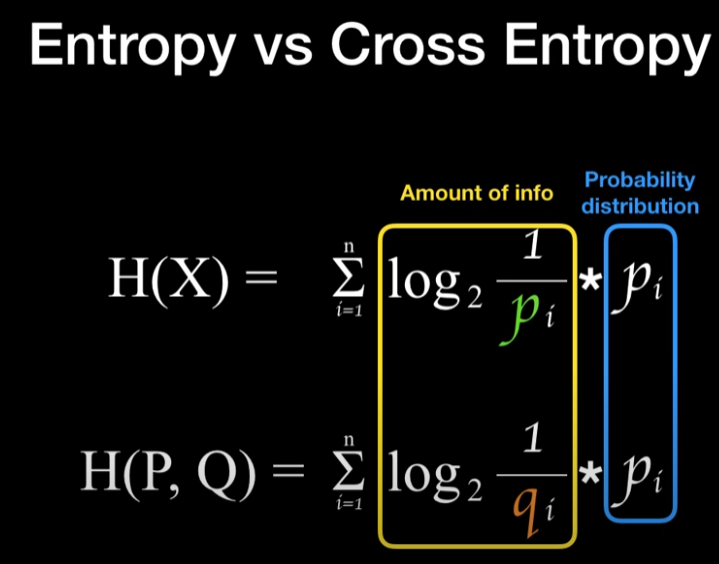

In [13]:
# train my model
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
print('Learning started. Waiting for training')
training_epochs=15
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. Waiting for training
[Epoch:    1] cost = 0.191568196
[Epoch:    2] cost = 0.0538561344
[Epoch:    3] cost = 0.0367551111
[Epoch:    4] cost = 0.0279533584
[Epoch:    5] cost = 0.0237495452
[Epoch:    6] cost = 0.0211030729
[Epoch:    7] cost = 0.0172656961
[Epoch:    8] cost = 0.015204371
[Epoch:    9] cost = 0.0134801567
[Epoch:   10] cost = 0.0126558971
[Epoch:   11] cost = 0.011392897
[Epoch:   12] cost = 0.0101414835
[Epoch:   13] cost = 0.00825232547
[Epoch:   14] cost = 0.00775396312
[Epoch:   15] cost = 0.00633195741
Learning Finished!


In [27]:
# Test model and check accuracy
# Pytorch에서 no_grad()와 eval()의 정확한 차이는 무엇일까? (https://coffeedjimmy.github.io/pytorch/2019/11/05/pytorch_nograd_vs_train_eval/)
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy1 = correct_prediction.float().mean()

    
    print('Accuracy:', accuracy1.item())

Accuracy: 0.9908999800682068
